<a href="https://colab.research.google.com/github/hertie-data-science-lab/tutorial-new-grp4/blob/main/DEEPL_Tutorial_xAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Explanability Methods for Machine- & Deep Learning
## GRAD-E1394 Deep Learning -- Assignment 3
Author(s):
*   Author, Email

<Replace the information in this cell with a brief summary of the tutorial as well as users' expected learning outcomes.>
TODO


# Table of Contents


*   [Memo](#memo)
*   [Overview](#overview)
*   [Background & Prerequisites](#background-and-prereqs)
*   [Software Requirements](#software-requirements)
*   [Data Description](#data-description)
*   [Methodology](#methodology)
*   [Results & Discussion](#results-and-discussion)
*   [References](#references)


# General Guidelines
*(Please remove this and other guideline sections from your final tutorial submission.)*

This template should help you create your tutorial. You may introduce modifications and extensions but adhere to the general principles for writing the tutorial:

*   Be brief.
    *  Keep it short and simple. Avoid unnecessary complexity.
*   Clearly illustrate how the content relates to public policy.
    *  Identify the ways in which this tutorial would help the users (your collegues) in their work.
*   Provide enough context.
    *  Explain important concepts directly in the tutorial notebook, but feel free to direct users to external resources when necessary.  
*   Avoid or minimize the use of jargon.
    *  Ideally, the content can be understood by both an ML audience and by people who are relatively new to ML and deep learning.
*   Focus on readability and usability.
    *  Interleave code cells with explanatory text, keeping your audience in mind.
*   Follow guidelines to avoid plagiarism.
    * Any verbatim text needs to be put in quotation marks.
    * Do not copy code.
    * Clearly reference ideas and work of others.
    * [Hertie School Code of Conduct](https://hertieschool-f4e6.kxcdn.com/fileadmin/5_WhoWeAre/Code_of_Conduct.pdf)
* Ensure reproducibility.
    * Ensure that your notebook can be rerun by somebody else on a different machine in a reasonable amount of time. If the task is computationally expensive, provide an additional, smaller data sample for fast reproduction, and use that in your tutorial.

## Additional Instructions
We highly recommend that you follow the [Ten simple rules for writing and sharing computational analyses using Jupyter Notebooks](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007007). We summarize the ten rules as follows:

<center><img src="https://journals.plos.org/ploscompbiol/article/figure/image?size=large&id=info:doi/10.1371/journal.pcbi.1007007.g001" width=400>

<small>Rule, Adam, et al. "Ten simple rules for writing and sharing computational analyses in Jupyter Notebooks." PLoS computational biology 15.7 (2019).</small></center>

### Rule 1: Tell a story for an audience
* Interleave explanatory text and code to tell a compelling story.
* Describe not just what you did but why you did it.
* How you tell your story depends on your goal and your audience.

### Rule 2: Document the process, not just the results
* Document relevant interactive explorations.
* Don't wait until the end to add explanatory text.
* Generate publication-ready version of figures from the get-go.

### Rule 3: Use cell divisions to make steps clear
* Each cell should perform one meaningful step in the analysis.
* Think one cell = one paragraph, function, or task (e.g. creating a plot).
* Avoid long cells (50+ lines)
* Organize your notebook into sections/subsections.  

### Rule 4: Modularize code
* Avoid duplicate code (no copy-pasting!)
* Wrap the code that you want to reuse in a function.
* Use descriptive and meaningful variable and function names.

### Rule 5: Record dependencies
* Manage your dependencies using a package or environment manager (e.g. pip,conda)
* Feel free to use tools like Binder or Docker to generate a "container" for better reproducibility.

### Rule 6: Use version control
- Google colab allows you to view revision history.
- You can also opt to use Git and Github for version control.
- As Jupyter uses JSON for serialization, tracking raw changes on GitHub is difficult. [ReviewNB](https://www.reviewnb.com/) and [nbdime](https://github.com/jupyter/nbdime) can help to generate human-readable diffs.

### Rule 7: Build a pipeline
* A well-designed notebook can be generalized into a pipeline.
* Place key variable declarations at the top/beginning of the notebook.
* Make a habit of regularly restarting your kernel and rerunning all cells.
* Before submitting, reinstall all dependencies and rerun all cells in a new enviroment to ensure reproducibility.

### Rule 8: Share and explain your data
* Properly reference the data you use.
* If using your own data, make your data or a sample of your data publicly available along with the notebook.
* You can opt to host public copies of your data.

### Rule 9: Design your notebooks to be read, run, and explored
* Read: For code hosted in a public repository, add README and LICENSE files.
* Run: Consider using Google Colab, Binder, or Docker for seamless replication.
* Explore: Consider how you can design your notebook so future users can built on top of your work.

### Rule 10: Advocate for open research

<a name="memo"></a>
# Memo

Write a memo for the leadership explaining in layman's terms why this topic is relevant for public policy. Discuss relevant research works, real-world examples of successful applications, and/or organizations and governments that apply such approaches for policy making.




<a name="overview"></a>
# Overview

In this section, provide a summary of the main contributions of the tutorial notebook. Note that the tutorial should introduce or demonstrate the use of a method, dataset, tool, or technology to address a problem related to public policy. Be clear on the goal of the tutorial and the expected learning outcomes for the users.


<a name="background-and-prereqs"></a>
# Background & Prerequisites

You will need to specify the prerequisites and basic knowledge required for the tutorial. Afterwards, please provide a brief explanation of the most important concepts necessary for the users to follow the tutorial.

## Reading materials
Please include additional resources (e.g. research papers, blog posts, textbooks) for the readers to further study the topic of your tutorial.


<a name="software-requirements"></a>
# Software Requirements
Include in this section the software requirements, setup instructions, and library imports.

Example:

This notebook requires Python >= 3.7. The following libraries are required:
*   pandas
*   numpy
*   matplotlib

In [8]:
!pip install pandas numpy matplotlib scikit-learn torch seaborn

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

In [3]:
SEED = 123

<a name="data-description"></a>
# Data Description

<In this section, kindly provide a brief description of the dataset that you will use in this tutorial. Specify information such as the data type or file format (e.g. text, image, video, tabular), size, spatial resolution, temporal resolution, labels or categories, etc. Explicitly name the source of your dataset. If you are introducing a new dataset, feel free to include additional information (e.g. field survey sampling methods, dataset annotation efforts, etc.) or provide external links and resources that discuss the specific details of the dataset.> TODO

- Source: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data


## Data Download
Provide instructions on how to retrieve the necessary data.

This may include bash scripts, Python scripts, or other means of downloading the data.

In [4]:
# we use this as it is nicely prepared (numerical recoding)
url = "https://raw.githubusercontent.com/rajasekarsr/Credit_Risk_Prediction_DataAnalysis/refs/heads/master/DATA/index.csv"
df = pd.read_csv(url)

## Data Preprocessing
Additionally, you can include any data preprocessing steps and exploratory data analyses (e.g. visualize data distributions, impute missing values, etc.) in this section to allow the users to better understand the dataset.

In this section, you might also want to describe the different input and output variables, the train/val/test splits, and any data transformations.

## Exploratory Data Analyis

In [5]:
# function to standarize the column names
def clean_columns(df):
    new_cols = []
    seen = {}
    for col in df.columns:
        # lowercase, replace non-alphanumeric with underscore
        clean = re.sub(r'\W+', '_', col.lower())
        clean = re.sub(r'_+', '_', clean).strip('_')
        # make unique
        if clean in seen:
            seen[clean] += 1
            clean = f"{clean}_{seen[clean]}"
        else:
            seen[clean] = 0
        new_cols.append(clean)
    df.columns = new_cols
    return df


df = clean_columns(df)

In [6]:
df.head(5)

,creditability,account_balance,duration_of_credit_month,payment_status_of_previous_credit,purpose,credit_amount,value_savings_stocks,length_of_current_employment,instalment_per_cent,sex_marital_status,...,duration_in_current_address,most_valuable_available_asset,age_years,concurrent_credits,type_of_apartment,no_of_credits_at_this_bank,occupation,no_of_dependents,telephone,foreign_worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


In [7]:
# datatypes

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   creditability                      1000 non-null   int64
 1   account_balance                    1000 non-null   int64
 2   duration_of_credit_month           1000 non-null   int64
 3   payment_status_of_previous_credit  1000 non-null   int64
 4   purpose                            1000 non-null   int64
 5   credit_amount                      1000 non-null   int64
 6   value_savings_stocks               1000 non-null   int64
 7   length_of_current_employment       1000 non-null   int64
 8   instalment_per_cent                1000 non-null   int64
 9   sex_marital_status                 1000 non-null   int64
 10  guarantors                         1000 non-null   int64
 11  duration_in_current_address        1000 non-null   int64
 12  most_valuable_availab

Key dataset characteristics:

- 1000 rows
- 20 numerical features (recoded from original dataset)
- Target: "creditability", i.e. credit-worthiness
- No missing values (as per dataset specification)

### Distribution

In [21]:
target_col = "creditability"
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()


Target value counts:
creditability
1    700
0    300
Name: count, dtype: int64


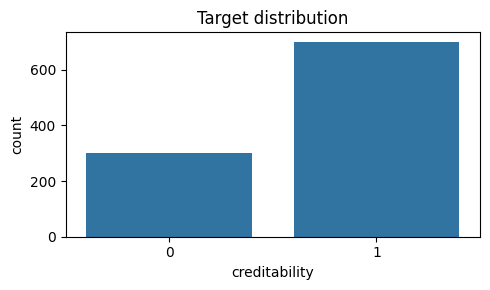

In [22]:
print("\nTarget value counts:")
print(df[target_col].value_counts())
plt.figure(figsize=(5,3))
sns.countplot(x=target_col, data=df)
plt.title("Target distribution")
plt.tight_layout()
plt.show()

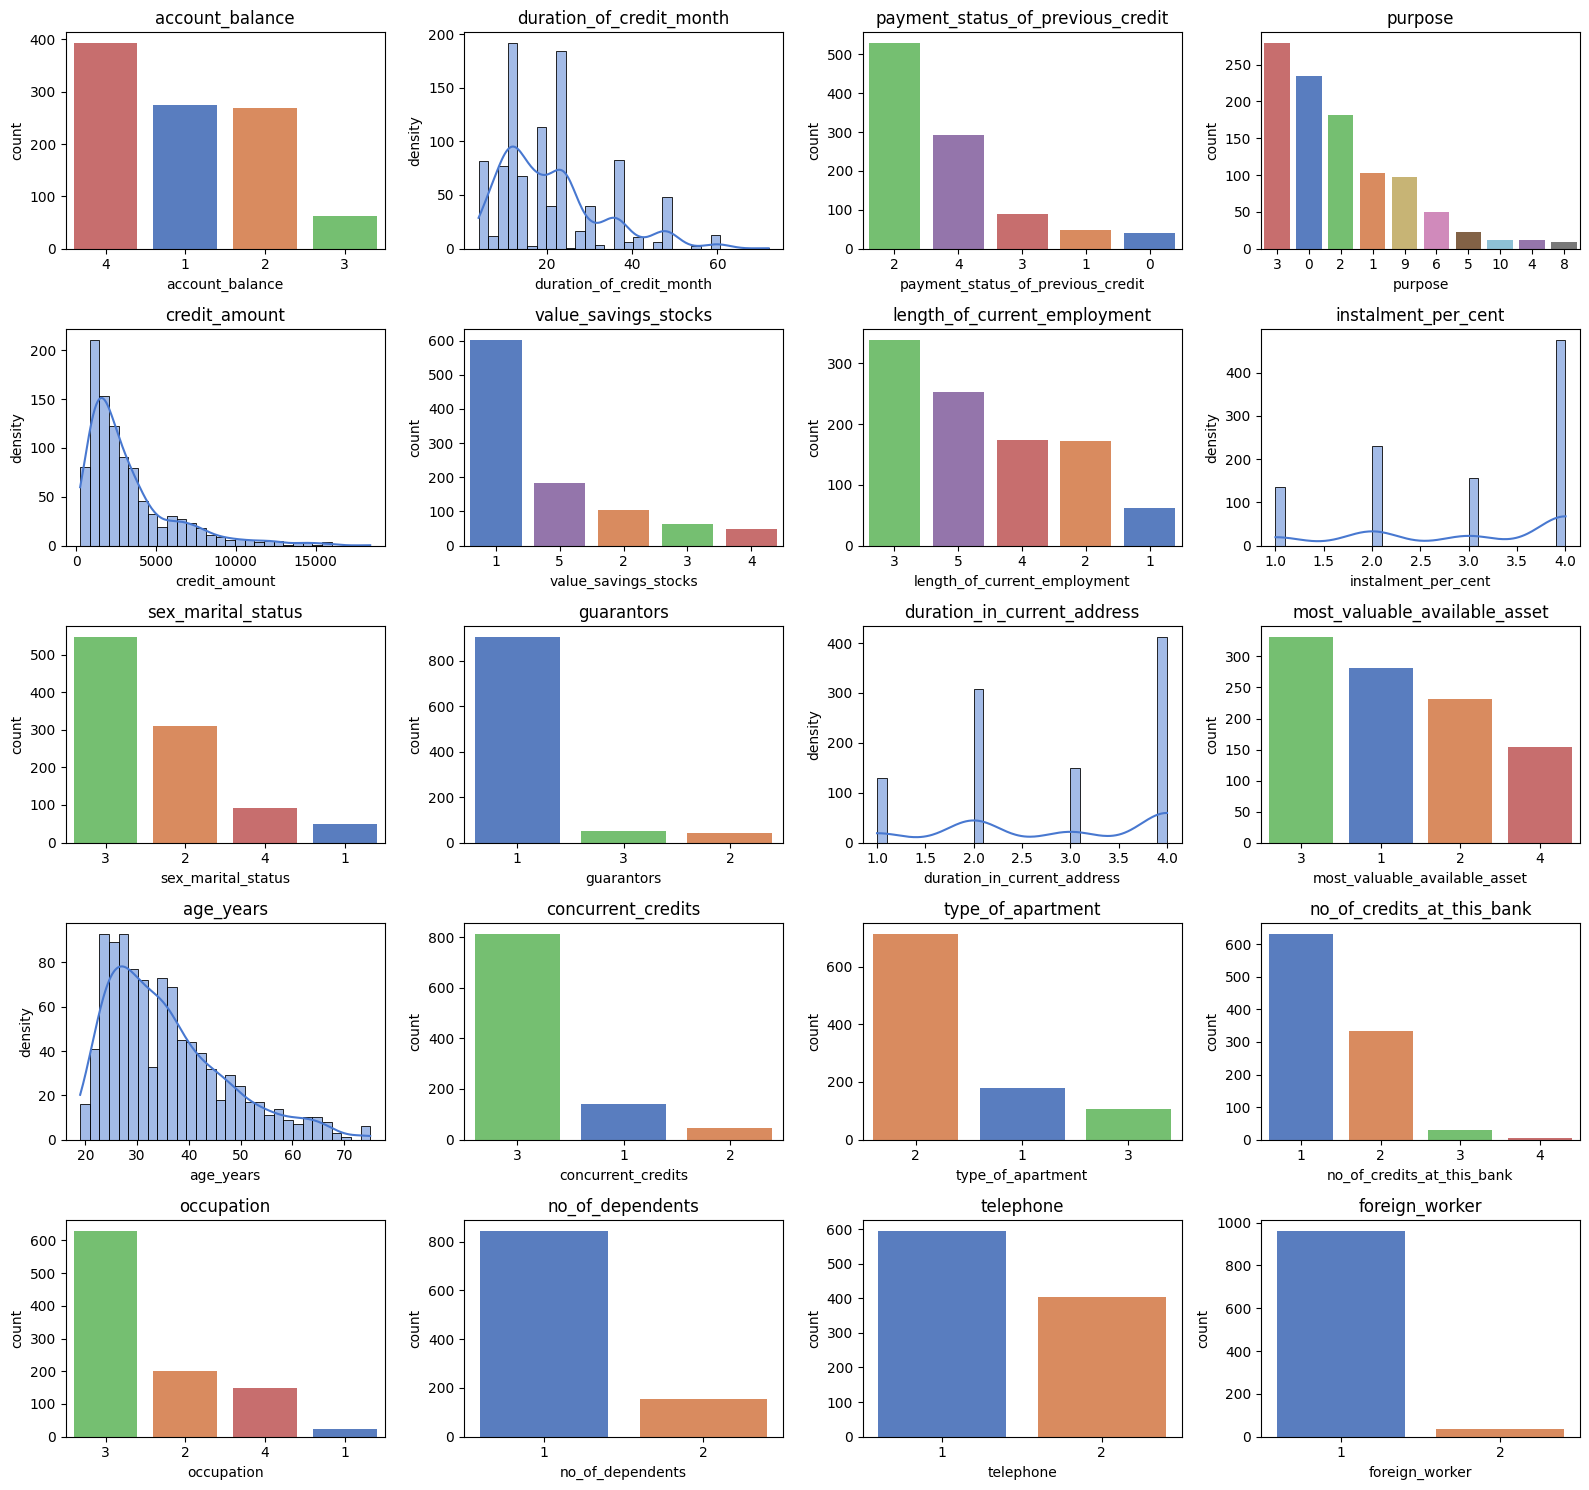

In [29]:
hist_cols = ["duration_of_credit_month", "credit_amount", "age_years", "instalment_per_cent", "duration_in_current_address"]  # adjust or set to None
palette_name = "muted"

plot_cols = num_cols.copy()
if target_col in plot_cols:
    plot_cols.remove(target_col)
plot_cols = [c for c in plot_cols if c in df.columns]

if hist_cols is None:
    hist_cols = [c for c in plot_cols if df[c].nunique() > 10]
hist_cols = [c for c in hist_cols if c in plot_cols]

max_plots = 20
plot_cols = plot_cols[:max_plots]
ncols = 4
nrows = int(np.ceil(len(plot_cols) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
axes = axes.flatten()

for idx, c in enumerate(plot_cols):
    ax = axes[idx]
    ser = df[c].dropna()

    if c in hist_cols:
        # use first color from the palette for consistency
        color = sns.color_palette(palette_name)[0]
        sns.histplot(ser, kde=True, ax=ax, bins=30, color=color)
        ax.set_ylabel("density")
    else:
        # order categories by frequency and build a palette with matching length
        order = ser.value_counts().index.tolist()
        pal_cats = sns.color_palette(palette_name, n_colors=len(order))
        # assign x to hue to avoid deprecated signature; remove legend for same visual
        sns.countplot(x=c, data=df, order=order, hue=c, ax=ax, palette=pal_cats)
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        ax.set_ylabel("count")

    ax.set_title(c)

# remove unused axes
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

TODO briefly summarize some observations

### Correlation of features & target

In [ ]:
corr = df[num_cols].corr()[target_col].abs().sort_values(ascending=False)
display(corr)


Absolute correlation of numeric features with target:


,creditability
creditability,1.000000
account_balance,0.350847
payment_status_of_previous_credit,0.228785
duration_of_credit_month,0.214927
value_savings_stocks,0.178943
credit_amount,0.154740
most_valuable_available_asset,0.142612
length_of_current_employment,0.116002
concurrent_credits,0.109844
age_years,0.091272


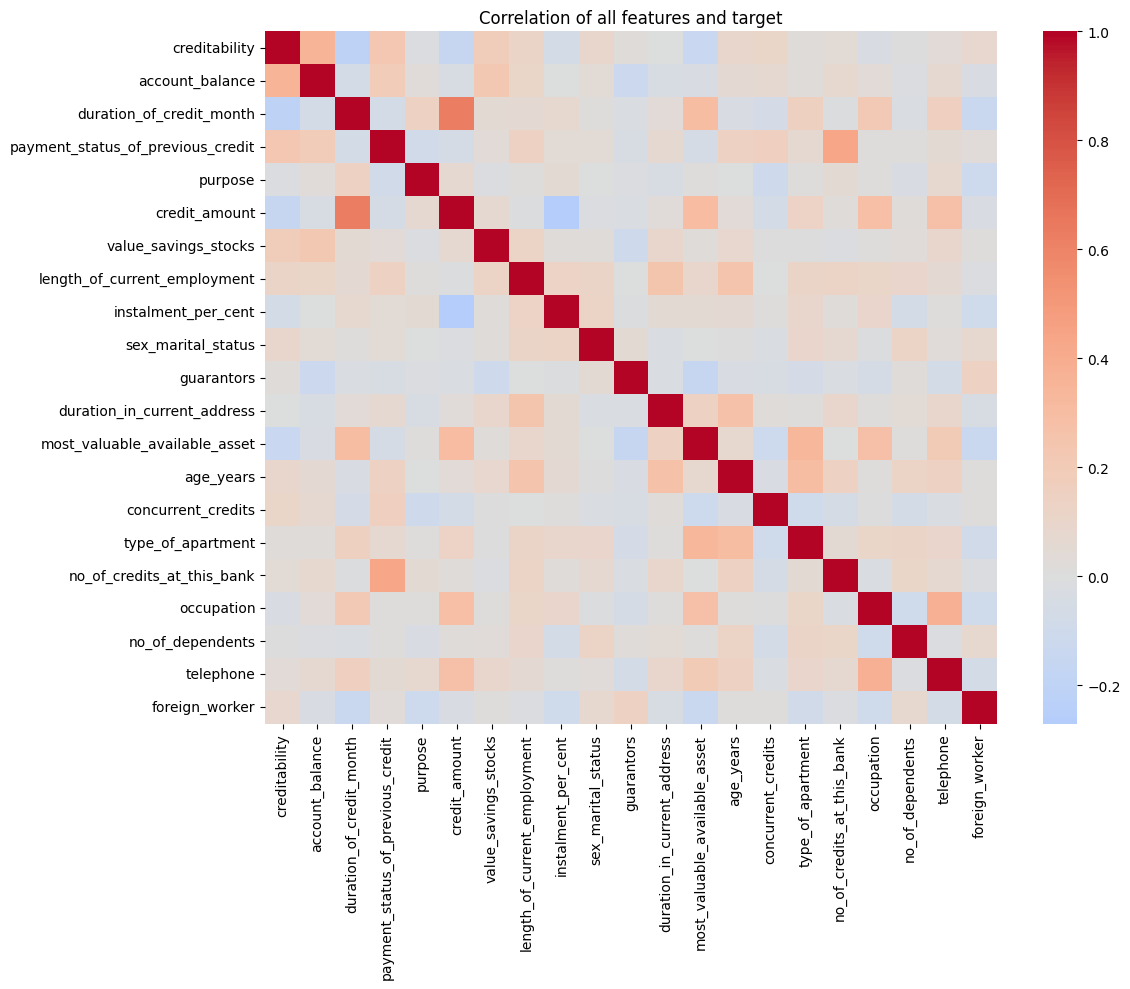

In [25]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Correlation of all features and target")
plt.tight_layout()
plt.show()


## Data splitting

In [ ]:
from sklearn.model_selection import train_test_split

target = df["creditability"]
features = df.drop(columns=["creditability"])

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=SEED)

In [ ]:
# check for equal size
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

# Modeling

### Model I: Random Forest Classifier

We are training a simple random forest classifier. Included in this code is a grid search procedure for finding the optimal hyperparameters for the model, as well as code to evaluate (test) the computed model.

Note: This next block may run a while, the grid search fits a lot of different models to compare.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [2, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

best_score = 0
best_rf = None
best_params = None

# custom loop function to enable tqdm progress bar
for params in tqdm(list(ParameterGrid(param_grid)), desc="Training RF"):
    rf = RandomForestClassifier(random_state=SEED, **params)
    scores = cross_val_score(rf, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_rf = rf
        best_params = params

best_rf.fit(X_train, y_train)
test_preds = best_rf.predict(X_test)

print("Best parameters:", best_params)
print("\nTest Accuracy:", accuracy_score(y_test, test_preds))
print("Test Classification Report:\n", classification_report(y_test, test_preds))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, test_preds))


### Model II: Neural Network

<a name="methodology"></a>
# Methodology

In this section, describe a step-by-step walkthrough of the methodology, in the form of code cells. Feel free to make use of markdown headings to break this section up into smaller subsections, preferrably one section per task.

Reminders:
*   Split the code into small, digestible chunks.
*   Use text cells to describe each code block.
*   Avoid duplicate code through modularization.
*   Focus on learning outcomes.

## Subtask Heading 1
Replace the heading with the appropriate title for each subtask.

In [ ]:
# Insert code here. Feel free to break this up into several code
# cells, interleaved with explanatory text.

## Subtask Heading 2
Replace the heading with the appropriate title for each subtask.

In [ ]:
# Insert code here. Feel free to break this up into several code
# cells, interleaved with explanatory text.

<a name="results-and-discussion"></a>
# Results & Discussion

In this section, describe and contextualize the results shown in the tutorial. Briefly describe the performance metrics and cross validation techniques used.

In [ ]:
# Insert code here. Feel free to break this up into several code
# cells, interleaved with explanatory text.

Finally, include a discussion on the limitations and important takeaways from the exercise.

## Limitations
*   The tutorial is focused on education and learning. Explain all the simplifications you have made compared to applying a similar approach in the real world (for instance, if you have reduced your training data and performance).
*   ML algorithms and datasets can reinforce or reflect unfair biases. Reflect on the potential biases in the dataset and/or analysis presented in your tutorial, including its potential societal impact, and discuss how readers might go about addressing this challenge.

## Next Steps
*   What do you recommend would be the next steps for your readers after finishing your tutorial?
*   Discuss other potential policy- and government-related applications for the method or tool discussed in the tutorial.
*   List anything else that you would want the reader to take away as they move on from the tutorial.

<a name="references"></a>
# References



## Acknowledgement


# Task
Integrate tqdm with GridSearchCV in the notebook to display a progress bar for the cross-validation process.

## Integrate tqdm with GridSearchCV

### Subtask:
Modify the existing `GridSearchCV` cell to use `tqdm_joblib` as a context manager around the `grid.fit` call to display a progress bar for the cross-validation process.


## Summary:

### Data Analysis Key Findings
No data analysis was performed in this step. The task involved modifying the existing `GridSearchCV` cell to integrate `tqdm_joblib` for displaying a progress bar, but no execution results or findings from this integration are available.

### Insights or Next Steps
*   The next step would be to execute the modified `GridSearchCV` with `tqdm_joblib` to observe and verify the progress bar functionality for the cross-validation process.
